## Image classification from scratch (https://keras.io/examples/vision/image_classification_from_scratch/)

### Introduction

This example shows how to do image classification from scratch, starting from JPEG image files on disk, without leveraging pre-trained weights or a pre-made Keras Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary classification dataset.

We use the image_dataset_from_directory utility to generate the datasets, and we use Keras image preprocessing layers for image standardization and data augmentation.

<hr />

### Setupimport os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt


In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

2025-04-03 02:12:18.943448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743646338.958782  374233 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743646338.963674  374233 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743646338.974699  374233 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743646338.974715  374233 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743646338.974717  374233 computation_placer.cc:177] computation placer alr

<hr />

### Load the data: the Cats vs Dogs dataset

#### Raw data download

First, let's download the 786M ZIP archive of the raw data:

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  18.3M      0  0:00:42  0:00:42 --:--:-- 13.3M


In [3]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 01-image_classification_from_scratch.ipynb   kagglecatsanddogs_5340.zip
 CDLA-Permissive-2.0.pdf		     'readme[1].txt'
 PetImages


Now we have a PetImages folder which contain two subfolders, Cat and Dog. Each subfolder contains image files for each category.

In [4]:
!ls PetImages

Cat  Dog


### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common occurence. Let's filter out badly-encoded images that do not feature the string "JFIF" in their header.

In [5]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


<hr />

#### Generate a Dataset

In [6]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


2025-04-03 02:18:21.401167: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


<hr />

### Visualize the data

Here are the first 9 images in the training dataset.

2025-04-03 02:19:03.554377: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


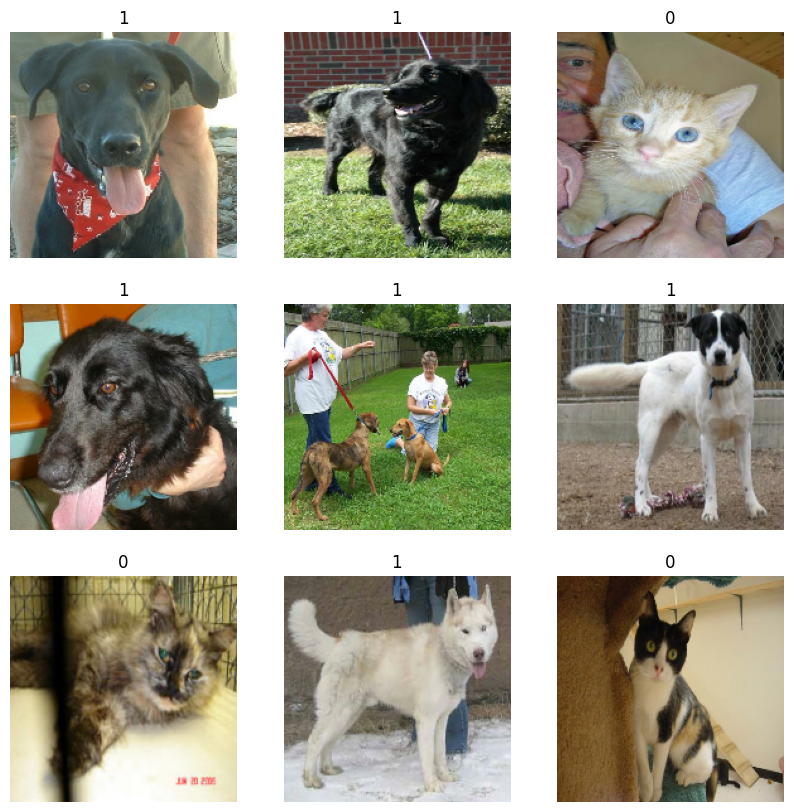

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

<hr />

### Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [8]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

Let's visualize what the augmented samples look like, by applying data_augmentation repeatedly to the first few images in the dataset:

2025-04-03 02:19:51.527863: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


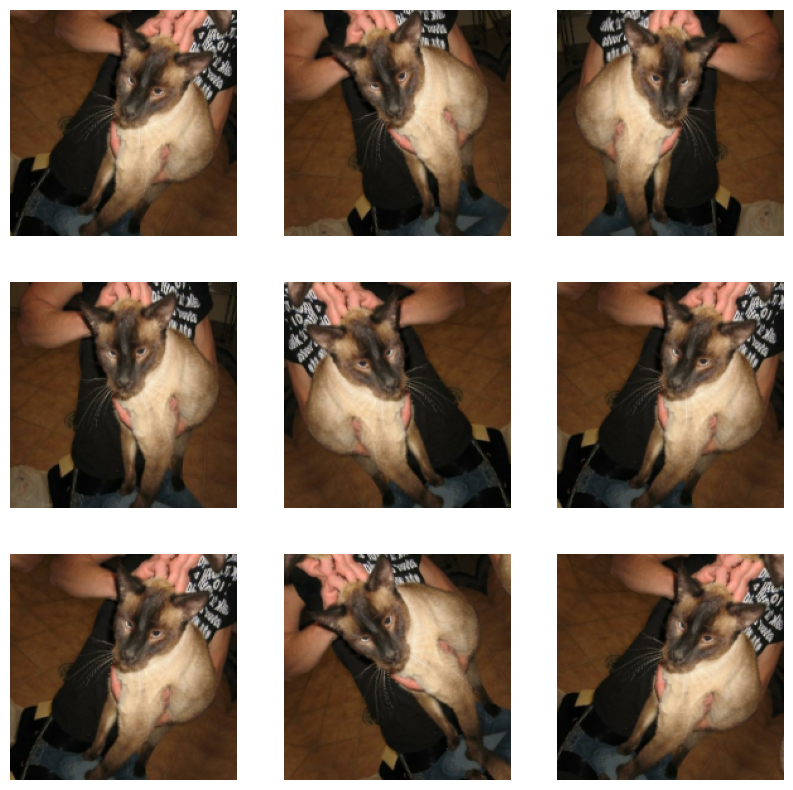

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

<hr />

### Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as contiguous float32 batches by our dataset. However, their RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer at the start of our model.

<hr />
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model

### Two options to preprocess the data

There are two ways you could be using the data_augmentation preprocessor:

<b>Option 1:</b> Make it part of the model, like this:

In [12]:
# inputs = keras.Input(shape=input_shape)
# x = data_augmentation(inputs)
# x = layers.Rescaling(1./255)(x)
# ...  # Rest of the model

With this option, your data augmentation will happen on device, synchronously with the rest of the model execution, meaning that it will benefit from GPU acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be augmented during fit(), not when calling evaluate() or predict().

If you're training on GPU, this may be a good option.

<b>Option 2:</b> apply it to the dataset, so as to obtain a dataset that yields batches of augmented images, like this:

In [13]:
# augmented_train_ds = train_ds.map(
#     lambda x, y: (data_augmentation(x, training=True), y))

With this option, your data augmentation will happen <b>on CPU</b>, asynchronously, and will be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation asynchronous and non-blocking.

In our case, we'll go with the second option. If you're not sure which one to pick, this second option (asynchronous preprocessing) is always a solid choice.

<hr />

### Configure the dataset for performance

Let's apply data augmentation to our training dataset, and let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking:

In [14]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

<hr />

### Build a model

We'll build a small version of the Xception network. We haven't particularly tried to optimize the architecture; if you want to do a systematic search for the best model configuration, consider using KerasTuner.

Note that:

<ul>
    <li>We start the model with the data_augmentation preprocessor, followed by a Rescaling layer.</li>
    <li>We include a Dropout layer before the final classification layer.</li>
</ul>

In [20]:
!pip install pydot
import pydot

In [21]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)
## plot_model doesn't work despite meeting the requirements they asked for.

You must install pydot (`pip install pydot`) for `plot_model` to work.


<hr />

### Train the model

In [22]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
2025-04-04 02:15:42.542413: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 530841600 exceeds 10% of free system memory.
2025-04-04 02:15:42.922060: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 530841600 exceeds 10% of free system memory.
2025-04-04 02:15:43.177338: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 530841600 exceeds 10% of free system memory.
2025-04-04 02:15:43.317387: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 265420800 exceeds 10% of free system memory.
2025-04-04 02:15:43.317413: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 530841600 exceeds 10% of free system memory.


 69/147 ━━━━━━━━━━━━━━━━━━━━ 31:34 24s/step - acc: 0.6159 - loss: 0.6561

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 77/147 ━━━━━━━━━━━━━━━━━━━━ 28:20 24s/step - acc: 0.6183 - loss: 0.6530

 97/147 ━━━━━━━━━━━━━━━━━━━━ 20:14 24s/step - acc: 0.6241 - loss: 0.6459

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


101/147 ━━━━━━━━━━━━━━━━━━━━ 18:39 24s/step - acc: 0.6253 - loss: 0.6446

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


123/147 ━━━━━━━━━━━━━━━━━━━━ 9:45 24s/step - acc: 0.6313 - loss: 0.6377 

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - acc: 0.6377 - loss: 0.6306 

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 3773s 26s/step - acc: 0.6379 - loss: 0.6303 - val_acc: 0.4957 - val_loss: 0.6964
Epoch 2/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 61/147 ━━━━━━━━━━━━━━━━━━━━ 35:19 25s/step - acc: 0.7534 - loss: 0.4956

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 80/147 ━━━━━━━━━━━━━━━━━━━━ 27:32 25s/step - acc: 0.7542 - loss: 0.4921

 92/147 ━━━━━━━━━━━━━━━━━━━━ 22:38 25s/step - acc: 0.7553 - loss: 0.4896

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 99/147 ━━━━━━━━━━━━━━━━━━━━ 19:46 25s/step - acc: 0.7561 - loss: 0.4881

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


101/147 ━━━━━━━━━━━━━━━━━━━━ 18:57 25s/step - acc: 0.7563 - loss: 0.4877

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


109/147 ━━━━━━━━━━━━━━━━━━━━ 15:40 25s/step - acc: 0.7572 - loss: 0.4860

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - acc: 0.7613 - loss: 0.4787 

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 3826s 26s/step - acc: 0.7614 - loss: 0.4786 - val_acc: 0.4957 - val_loss: 0.6919
Epoch 3/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 71/147 ━━━━━━━━━━━━━━━━━━━━ 31:09 25s/step - acc: 0.8112 - loss: 0.3946

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 72/147 ━━━━━━━━━━━━━━━━━━━━ 30:44 25s/step - acc: 0.8113 - loss: 0.3945

 92/147 ━━━━━━━━━━━━━━━━━━━━ 22:34 25s/step - acc: 0.8130 - loss: 0.3918

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 94/147 ━━━━━━━━━━━━━━━━━━━━ 21:47 25s/step - acc: 0.8132 - loss: 0.3915

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 99/147 ━━━━━━━━━━━━━━━━━━━━ 19:46 25s/step - acc: 0.8137 - loss: 0.3909

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - acc: 0.8170 - loss: 0.3858 

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 3819s 26s/step - acc: 0.8171 - loss: 0.3857 - val_acc: 0.4957 - val_loss: 0.6907
Epoch 4/25
  3/147 ━━━━━━━━━━━━━━━━━━━━ 59:13 25s/step - acc: 0.8108 - loss: 0.3671

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 67/147 ━━━━━━━━━━━━━━━━━━━━ 32:53 25s/step - acc: 0.8441 - loss: 0.3408

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 70/147 ━━━━━━━━━━━━━━━━━━━━ 31:39 25s/step - acc: 0.8446 - loss: 0.3401

 96/147 ━━━━━━━━━━━━━━━━━━━━ 21:00 25s/step - acc: 0.8477 - loss: 0.3352

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 98/147 ━━━━━━━━━━━━━━━━━━━━ 20:10 25s/step - acc: 0.8480 - loss: 0.3349

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


102/147 ━━━━━━━━━━━━━━━━━━━━ 18:31 25s/step - acc: 0.8484 - loss: 0.3342

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - acc: 0.8524 - loss: 0.3272 

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 3821s 26s/step - acc: 0.8524 - loss: 0.3271 - val_acc: 0.4957 - val_loss: 0.8074
Epoch 5/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 65/147 ━━━━━━━━━━━━━━━━━━━━ 33:44 25s/step - acc: 0.8626 - loss: 0.2966

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 90/147 ━━━━━━━━━━━━━━━━━━━━ 23:27 25s/step - acc: 0.8637 - loss: 0.2947

 98/147 ━━━━━━━━━━━━━━━━━━━━ 20:10 25s/step - acc: 0.8640 - loss: 0.2944

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 99/147 ━━━━━━━━━━━━━━━━━━━━ 19:45 25s/step - acc: 0.8640 - loss: 0.2944

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


104/147 ━━━━━━━━━━━━━━━━━━━━ 17:41 25s/step - acc: 0.8642 - loss: 0.2941

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


114/147 ━━━━━━━━━━━━━━━━━━━━ 13:34 25s/step - acc: 0.8645 - loss: 0.2936

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - acc: 0.8661 - loss: 0.2908 

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 3813s 26s/step - acc: 0.8662 - loss: 0.2907 - val_acc: 0.7287 - val_loss: 0.4472
Epoch 6/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 72/147 ━━━━━━━━━━━━━━━━━━━━ 30:52 25s/step - acc: 0.8961 - loss: 0.2524

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 83/147 ━━━━━━━━━━━━━━━━━━━━ 26:19 25s/step - acc: 0.8961 - loss: 0.2511

100/147 ━━━━━━━━━━━━━━━━━━━━ 19:20 25s/step - acc: 0.8961 - loss: 0.2500

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


102/147 ━━━━━━━━━━━━━━━━━━━━ 18:30 25s/step - acc: 0.8961 - loss: 0.2499

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


107/147 ━━━━━━━━━━━━━━━━━━━━ 16:27 25s/step - acc: 0.8961 - loss: 0.2496

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


108/147 ━━━━━━━━━━━━━━━━━━━━ 16:02 25s/step - acc: 0.8961 - loss: 0.2495

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - acc: 0.8962 - loss: 0.2468 

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 3817s 26s/step - acc: 0.8962 - loss: 0.2468 - val_acc: 0.8279 - val_loss: 0.3150
Epoch 7/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 59/147 ━━━━━━━━━━━━━━━━━━━━ 36:10 25s/step - acc: 0.9017 - loss: 0.2288

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 69/147 ━━━━━━━━━━━━━━━━━━━━ 32:03 25s/step - acc: 0.9017 - loss: 0.2285

 90/147 ━━━━━━━━━━━━━━━━━━━━ 23:26 25s/step - acc: 0.9019 - loss: 0.2275

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 93/147 ━━━━━━━━━━━━━━━━━━━━ 22:12 25s/step - acc: 0.9020 - loss: 0.2274

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 94/147 ━━━━━━━━━━━━━━━━━━━━ 21:47 25s/step - acc: 0.9020 - loss: 0.2273

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - acc: 0.9028 - loss: 0.2254 

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 3811s 26s/step - acc: 0.9029 - loss: 0.2253 - val_acc: 0.8543 - val_loss: 0.4377
Epoch 8/25
  7/147 ━━━━━━━━━━━━━━━━━━━━ 57:18 25s/step - acc: 0.9207 - loss: 0.2183

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 69/147 ━━━━━━━━━━━━━━━━━━━━ 32:06 25s/step - acc: 0.9162 - loss: 0.2010

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 78/147 ━━━━━━━━━━━━━━━━━━━━ 28:23 25s/step - acc: 0.9160 - loss: 0.2006

 90/147 ━━━━━━━━━━━━━━━━━━━━ 23:26 25s/step - acc: 0.9157 - loss: 0.2002

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 96/147 ━━━━━━━━━━━━━━━━━━━━ 20:57 25s/step - acc: 0.9154 - loss: 0.2002

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


101/147 ━━━━━━━━━━━━━━━━━━━━ 18:54 25s/step - acc: 0.9153 - loss: 0.2002

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


104/147 ━━━━━━━━━━━━━━━━━━━━ 17:40 25s/step - acc: 0.9152 - loss: 0.2002

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - acc: 0.9147 - loss: 0.1999 

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 3811s 26s/step - acc: 0.9147 - loss: 0.1999 - val_acc: 0.8672 - val_loss: 0.2421
Epoch 9/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 1:03:21 26s/step - acc: 0.9453 - loss: 0.1674

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 64/147 ━━━━━━━━━━━━━━━━━━━━ 34:09 25s/step - acc: 0.9208 - loss: 0.1828

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 93/147 ━━━━━━━━━━━━━━━━━━━━ 22:11 25s/step - acc: 0.9210 - loss: 0.1820

 94/147 ━━━━━━━━━━━━━━━━━━━━ 21:46 25s/step - acc: 0.9210 - loss: 0.1820

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 98/147 ━━━━━━━━━━━━━━━━━━━━ 20:07 25s/step - acc: 0.9210 - loss: 0.1820

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


100/147 ━━━━━━━━━━━━━━━━━━━━ 19:18 25s/step - acc: 0.9210 - loss: 0.1820

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


105/147 ━━━━━━━━━━━━━━━━━━━━ 17:15 25s/step - acc: 0.9210 - loss: 0.1820

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - acc: 0.9213 - loss: 0.1811 

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 3808s 26s/step - acc: 0.9213 - loss: 0.1811 - val_acc: 0.9084 - val_loss: 0.1971
Epoch 10/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 73/147 ━━━━━━━━━━━━━━━━━━━━ 30:28 25s/step - acc: 0.9299 - loss: 0.1728

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 92/147 ━━━━━━━━━━━━━━━━━━━━ 22:37 25s/step - acc: 0.9298 - loss: 0.1730

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


100/147 ━━━━━━━━━━━━━━━━━━━━ 19:20 25s/step - acc: 0.9296 - loss: 0.1732

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


102/147 ━━━━━━━━━━━━━━━━━━━━ 18:30 25s/step - acc: 0.9296 - loss: 0.1732

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - acc: 0.9292 - loss: 0.1732 

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 3809s 26s/step - acc: 0.9292 - loss: 0.1732 - val_acc: 0.9116 - val_loss: 0.2023
Epoch 11/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 62/147 ━━━━━━━━━━━━━━━━━━━━ 34:53 25s/step - acc: 0.9275 - loss: 0.1663

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 74/147 ━━━━━━━━━━━━━━━━━━━━ 29:56 25s/step - acc: 0.9285 - loss: 0.1643

 96/147 ━━━━━━━━━━━━━━━━━━━━ 20:57 25s/step - acc: 0.9298 - loss: 0.1619

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 98/147 ━━━━━━━━━━━━━━━━━━━━ 20:08 25s/step - acc: 0.9298 - loss: 0.1618

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


106/147 ━━━━━━━━━━━━━━━━━━━━ 16:50 25s/step - acc: 0.9301 - loss: 0.1612

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


109/147 ━━━━━━━━━━━━━━━━━━━━ 15:36 25s/step - acc: 0.9302 - loss: 0.1610

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - acc: 0.9309 - loss: 0.1592 

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 3810s 26s/step - acc: 0.9310 - loss: 0.1592 - val_acc: 0.9338 - val_loss: 0.1701
Epoch 12/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 73/147 ━━━━━━━━━━━━━━━━━━━━ 30:23 25s/step - acc: 0.9401 - loss: 0.1391

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 81/147 ━━━━━━━━━━━━━━━━━━━━ 27:05 25s/step - acc: 0.9405 - loss: 0.1387

 93/147 ━━━━━━━━━━━━━━━━━━━━ 22:09 25s/step - acc: 0.9409 - loss: 0.1384

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 94/147 ━━━━━━━━━━━━━━━━━━━━ 21:45 25s/step - acc: 0.9410 - loss: 0.1384

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 97/147 ━━━━━━━━━━━━━━━━━━━━ 20:31 25s/step - acc: 0.9410 - loss: 0.1384

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


103/147 ━━━━━━━━━━━━━━━━━━━━ 18:03 25s/step - acc: 0.9411 - loss: 0.1383

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - acc: 0.9415 - loss: 0.1379 

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 3811s 26s/step - acc: 0.9415 - loss: 0.1379 - val_acc: 0.9097 - val_loss: 0.2830
Epoch 13/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 73/147 ━━━━━━━━━━━━━━━━━━━━ 30:22 25s/step - acc: 0.9439 - loss: 0.1383

 75/147 ━━━━━━━━━━━━━━━━━━━━ 29:32 25s/step - acc: 0.9439 - loss: 0.1383

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 90/147 ━━━━━━━━━━━━━━━━━━━━ 23:23 25s/step - acc: 0.9438 - loss: 0.1383

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 94/147 ━━━━━━━━━━━━━━━━━━━━ 21:44 25s/step - acc: 0.9438 - loss: 0.1383

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 97/147 ━━━━━━━━━━━━━━━━━━━━ 20:30 25s/step - acc: 0.9438 - loss: 0.1383

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


110/147 ━━━━━━━━━━━━━━━━━━━━ 15:10 25s/step - acc: 0.9436 - loss: 0.1383

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - acc: 0.9430 - loss: 0.1386 

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 3804s 26s/step - acc: 0.9430 - loss: 0.1386 - val_acc: 0.8422 - val_loss: 0.2842
Epoch 14/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 63/147 ━━━━━━━━━━━━━━━━━━━━ 34:34 25s/step - acc: 0.9488 - loss: 0.1273

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 77/147 ━━━━━━━━━━━━━━━━━━━━ 28:47 25s/step - acc: 0.9483 - loss: 0.1274

 90/147 ━━━━━━━━━━━━━━━━━━━━ 23:25 25s/step - acc: 0.9477 - loss: 0.1278

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 96/147 ━━━━━━━━━━━━━━━━━━━━ 20:57 25s/step - acc: 0.9474 - loss: 0.1281

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 97/147 ━━━━━━━━━━━━━━━━━━━━ 20:32 25s/step - acc: 0.9474 - loss: 0.1281

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - acc: 0.9464 - loss: 0.1289 

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 3812s 26s/step - acc: 0.9464 - loss: 0.1289 - val_acc: 0.9199 - val_loss: 0.2333
Epoch 15/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 60/147 ━━━━━━━━━━━━━━━━━━━━ 35:34 25s/step - acc: 0.9478 - loss: 0.1295

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 83/147 ━━━━━━━━━━━━━━━━━━━━ 26:10 25s/step - acc: 0.9482 - loss: 0.1274

 96/147 ━━━━━━━━━━━━━━━━━━━━ 20:51 25s/step - acc: 0.9483 - loss: 0.1268

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 97/147 ━━━━━━━━━━━━━━━━━━━━ 20:27 25s/step - acc: 0.9483 - loss: 0.1267

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 98/147 ━━━━━━━━━━━━━━━━━━━━ 20:02 25s/step - acc: 0.9482 - loss: 0.1267

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 99/147 ━━━━━━━━━━━━━━━━━━━━ 19:38 25s/step - acc: 0.9482 - loss: 0.1267

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - acc: 0.9482 - loss: 0.1249 

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 3800s 26s/step - acc: 0.9482 - loss: 0.1249 - val_acc: 0.9366 - val_loss: 0.1436
Epoch 16/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 59/147 ━━━━━━━━━━━━━━━━━━━━ 36:04 25s/step - acc: 0.9494 - loss: 0.1156

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 67/147 ━━━━━━━━━━━━━━━━━━━━ 32:48 25s/step - acc: 0.9494 - loss: 0.1154

 91/147 ━━━━━━━━━━━━━━━━━━━━ 22:58 25s/step - acc: 0.9495 - loss: 0.1151

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 96/147 ━━━━━━━━━━━━━━━━━━━━ 20:55 25s/step - acc: 0.9496 - loss: 0.1151

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


100/147 ━━━━━━━━━━━━━━━━━━━━ 19:17 25s/step - acc: 0.9496 - loss: 0.1151

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - acc: 0.9499 - loss: 0.1151 

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 3815s 26s/step - acc: 0.9499 - loss: 0.1151 - val_acc: 0.9180 - val_loss: 0.2445
Epoch 17/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 64/147 ━━━━━━━━━━━━━━━━━━━━ 34:07 25s/step - acc: 0.9534 - loss: 0.1106

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 72/147 ━━━━━━━━━━━━━━━━━━━━ 30:50 25s/step - acc: 0.9536 - loss: 0.1102

 92/147 ━━━━━━━━━━━━━━━━━━━━ 22:37 25s/step - acc: 0.9541 - loss: 0.1096

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 97/147 ━━━━━━━━━━━━━━━━━━━━ 20:33 25s/step - acc: 0.9541 - loss: 0.1096

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 98/147 ━━━━━━━━━━━━━━━━━━━━ 20:09 25s/step - acc: 0.9541 - loss: 0.1096

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 99/147 ━━━━━━━━━━━━━━━━━━━━ 19:44 25s/step - acc: 0.9541 - loss: 0.1095

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - acc: 0.9542 - loss: 0.1090 

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 3818s 26s/step - acc: 0.9542 - loss: 0.1090 - val_acc: 0.9329 - val_loss: 0.1889
Epoch 18/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 62/147 ━━━━━━━━━━━━━━━━━━━━ 34:51 25s/step - acc: 0.9488 - loss: 0.1235

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 67/147 ━━━━━━━━━━━━━━━━━━━━ 32:48 25s/step - acc: 0.9493 - loss: 0.1224

 90/147 ━━━━━━━━━━━━━━━━━━━━ 23:22 25s/step - acc: 0.9509 - loss: 0.1185

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 91/147 ━━━━━━━━━━━━━━━━━━━━ 22:58 25s/step - acc: 0.9510 - loss: 0.1184

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 94/147 ━━━━━━━━━━━━━━━━━━━━ 21:44 25s/step - acc: 0.9511 - loss: 0.1181

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 98/147 ━━━━━━━━━━━━━━━━━━━━ 20:05 25s/step - acc: 0.9513 - loss: 0.1176

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - acc: 0.9525 - loss: 0.1142 

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 3807s 26s/step - acc: 0.9525 - loss: 0.1142 - val_acc: 0.9156 - val_loss: 0.2664
Epoch 19/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 69/147 ━━━━━━━━━━━━━━━━━━━━ 32:00 25s/step - acc: 0.9576 - loss: 0.1042

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 75/147 ━━━━━━━━━━━━━━━━━━━━ 29:32 25s/step - acc: 0.9576 - loss: 0.1041

 93/147 ━━━━━━━━━━━━━━━━━━━━ 22:12 25s/step - acc: 0.9576 - loss: 0.1038

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


106/147 ━━━━━━━━━━━━━━━━━━━━ 16:51 25s/step - acc: 0.9575 - loss: 0.1036

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


113/147 ━━━━━━━━━━━━━━━━━━━━ 13:58 25s/step - acc: 0.9575 - loss: 0.1036

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


121/147 ━━━━━━━━━━━━━━━━━━━━ 10:41 25s/step - acc: 0.9575 - loss: 0.1035

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - acc: 0.9575 - loss: 0.1032 

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 3814s 26s/step - acc: 0.9575 - loss: 0.1031 - val_acc: 0.8930 - val_loss: 0.1999
Epoch 20/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 68/147 ━━━━━━━━━━━━━━━━━━━━ 32:31 25s/step - acc: 0.9646 - loss: 0.0962

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 73/147 ━━━━━━━━━━━━━━━━━━━━ 30:27 25s/step - acc: 0.9647 - loss: 0.0957

 90/147 ━━━━━━━━━━━━━━━━━━━━ 23:30 25s/step - acc: 0.9647 - loss: 0.0947

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 95/147 ━━━━━━━━━━━━━━━━━━━━ 21:26 25s/step - acc: 0.9647 - loss: 0.0946

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


100/147 ━━━━━━━━━━━━━━━━━━━━ 19:22 25s/step - acc: 0.9647 - loss: 0.0945

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


113/147 ━━━━━━━━━━━━━━━━━━━━ 14:01 25s/step - acc: 0.9647 - loss: 0.0942

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - acc: 0.9645 - loss: 0.0938 

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 3821s 26s/step - acc: 0.9645 - loss: 0.0938 - val_acc: 0.9263 - val_loss: 0.2062
Epoch 21/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 64/147 ━━━━━━━━━━━━━━━━━━━━ 34:08 25s/step - acc: 0.9540 - loss: 0.1072

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 82/147 ━━━━━━━━━━━━━━━━━━━━ 26:48 25s/step - acc: 0.9550 - loss: 0.1058

 93/147 ━━━━━━━━━━━━━━━━━━━━ 22:16 25s/step - acc: 0.9556 - loss: 0.1051

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


103/147 ━━━━━━━━━━━━━━━━━━━━ 18:08 25s/step - acc: 0.9560 - loss: 0.1044

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


115/147 ━━━━━━━━━━━━━━━━━━━━ 13:11 25s/step - acc: 0.9565 - loss: 0.1037

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


132/147 ━━━━━━━━━━━━━━━━━━━━ 6:11 25s/step - acc: 0.9572 - loss: 0.1025

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - acc: 0.9577 - loss: 0.1016 

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 3827s 26s/step - acc: 0.9578 - loss: 0.1015 - val_acc: 0.9120 - val_loss: 0.1879
Epoch 22/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 67/147 ━━━━━━━━━━━━━━━━━━━━ 33:12 25s/step - acc: 0.9648 - loss: 0.0822

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 74/147 ━━━━━━━━━━━━━━━━━━━━ 30:17 25s/step - acc: 0.9650 - loss: 0.0820

 92/147 ━━━━━━━━━━━━━━━━━━━━ 22:49 25s/step - acc: 0.9652 - loss: 0.0819

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 94/147 ━━━━━━━━━━━━━━━━━━━━ 21:59 25s/step - acc: 0.9652 - loss: 0.0819

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 98/147 ━━━━━━━━━━━━━━━━━━━━ 20:19 25s/step - acc: 0.9652 - loss: 0.0819

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


100/147 ━━━━━━━━━━━━━━━━━━━━ 19:29 25s/step - acc: 0.9652 - loss: 0.0818

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - acc: 0.9656 - loss: 0.0819 

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 3843s 26s/step - acc: 0.9656 - loss: 0.0819 - val_acc: 0.9447 - val_loss: 0.1517
Epoch 23/25
  3/147 ━━━━━━━━━━━━━━━━━━━━ 59:24 25s/step - acc: 0.9796 - loss: 0.0721

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 70/147 ━━━━━━━━━━━━━━━━━━━━ 31:51 25s/step - acc: 0.9722 - loss: 0.0754

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 88/147 ━━━━━━━━━━━━━━━━━━━━ 24:23 25s/step - acc: 0.9715 - loss: 0.0765

 90/147 ━━━━━━━━━━━━━━━━━━━━ 23:33 25s/step - acc: 0.9715 - loss: 0.0766

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 93/147 ━━━━━━━━━━━━━━━━━━━━ 22:19 25s/step - acc: 0.9714 - loss: 0.0768

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


106/147 ━━━━━━━━━━━━━━━━━━━━ 16:56 25s/step - acc: 0.9709 - loss: 0.0776

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - acc: 0.9697 - loss: 0.0790 

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 3834s 26s/step - acc: 0.9697 - loss: 0.0790 - val_acc: 0.9413 - val_loss: 0.1763
Epoch 24/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 67/147 ━━━━━━━━━━━━━━━━━━━━ 33:02 25s/step - acc: 0.9643 - loss: 0.0862

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 68/147 ━━━━━━━━━━━━━━━━━━━━ 32:37 25s/step - acc: 0.9644 - loss: 0.0862

 88/147 ━━━━━━━━━━━━━━━━━━━━ 25:20 26s/step - acc: 0.9650 - loss: 0.0852

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 95/147 ━━━━━━━━━━━━━━━━━━━━ 23:00 27s/step - acc: 0.9651 - loss: 0.0849

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 96/147 ━━━━━━━━━━━━━━━━━━━━ 22:37 27s/step - acc: 0.9652 - loss: 0.0848

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


105/147 ━━━━━━━━━━━━━━━━━━━━ 18:37 27s/step - acc: 0.9653 - loss: 0.0845

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - acc: 0.9659 - loss: 0.0835 

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 4020s 27s/step - acc: 0.9659 - loss: 0.0835 - val_acc: 0.9327 - val_loss: 0.2121
Epoch 25/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 61/147 ━━━━━━━━━━━━━━━━━━━━ 35:25 25s/step - acc: 0.9721 - loss: 0.0719

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 72/147 ━━━━━━━━━━━━━━━━━━━━ 30:52 25s/step - acc: 0.9720 - loss: 0.0717

 92/147 ━━━━━━━━━━━━━━━━━━━━ 22:37 25s/step - acc: 0.9717 - loss: 0.0721

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


102/147 ━━━━━━━━━━━━━━━━━━━━ 18:29 25s/step - acc: 0.9715 - loss: 0.0725

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


104/147 ━━━━━━━━━━━━━━━━━━━━ 17:40 25s/step - acc: 0.9714 - loss: 0.0726

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - acc: 0.9705 - loss: 0.0740 

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 3807s 26s/step - acc: 0.9705 - loss: 0.0741 - val_acc: 0.9466 - val_loss: 0.1574


We get to >90% validation accuracy after training for 25 epochs on the full dataset (in practice, you can train for 50+ epochs before validation performance starts degrading).

<hr />

### Run inference on new data

Note that data augmentation and dropout are inactive at inference time

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
This image is 90.95% cat and 9.05% dog.


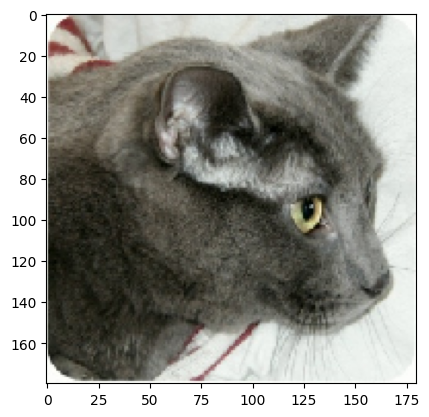

In [24]:
img = keras.utils.load_img("PetImages/Cat/6779.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")